#Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install segmentation-models-3D

In [ ]:
#Libraries and imports
#Nibabel for reading medical imaging files in NIfTI format (.nii or .nii.gz)
import nibabel as nib
#Numerical computations and importantly array manipulation
import numpy as np
if not hasattr(np, 'Inf'):
    np.Inf = np.inf
import cv2
import imageio
import random
#File path operations
import os
import shutil
#Pattern matching and retrieving file paths
import glob
#Important visualization for preprocessing and results
import matplotlib.pyplot as plt
#DL library
import tensorflow as tf
import zipfile
from IPython.display import Image, display
from tensorflow import keras
#Autodownload files
from google.colab import files
#Mixed precision for faster computation and reduced memory usage
from tensorflow.keras import mixed_precision
#All layers necessary to UNet model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Conv3DTranspose, Cropping3D, ZeroPadding3D
#For Importing model after training
from tensorflow.keras.models import Model, load_model
#Converting segmentation masks into one-hot encoded forms
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import register_keras_serializable
#Standard Classification of loss
from tensorflow.keras.losses import CategoricalCrossentropy
#Important callback fo radjusting learning rate while training and saving checkpoints
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
#Splitting data into training and validation sets
from sklearn.model_selection import train_test_split
#Data augmentation like rotating and filtering
from scipy.ndimage import rotate, gaussian_filter
#Loss function for segmentation
from segmentation_models_3D.losses import DiceLoss
#Metrics to evaluatate segmentation accuracy
from segmentation_models_3D.metrics import IOUScore, FScore

Segmentation Models: using `keras` framework.


In [ ]:
#Defined base path to the BraTS dataset (unzipped in .nii.gz format)
base_path = '/content/drive/MyDrive/Brats_Dataset/TrainingData'

In [ ]:
#Mixed precision policy set from beginning to optimize memory usage and improve training times
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
import zipfile
import os
from google.colab import drive

zip_path = "/content/drive/MyDrive/DataSets/archive.zip"
extract_dir = "/content/drive/MyDrive/Brats_Dataset"

if not os.path.exists(extract_dir):
  print("Unzipping...")
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
  print("Done")
else:
  print("Failed")

Unzipping...
Done


In [ ]:
import tarfile
import glob

tar_files = glob.glob("/content/drive/MyDrive/Brats_Dataset/*.tar")

for tar_path in tar_files:
  print(f"Extracting {os.path.basename(tar_path)}...")
  with tarfile.open(tar_path) as tar:
    tar.extractall(path="/content/drive/MyDrive/Brats_Dataset")
    print("Done")

print("All Done")

All Done


In [ ]:
# ──────────────── Sanity check cell ────────────────
from pathlib import Path

root = Path('/content/drive/MyDrive/Brats_Dataset')

# 1) Sample a few subject folders
print("Sample subjects:", sorted(p.name for p in root.joinpath('TrainingData').iterdir())[:5])

# 2) Count **all** .nii/.nii.gz files under Dataset1
all_nii = list(root.rglob('*.nii*'))
print("Total volumes (all .nii/.nii.gz):", len(all_nii))

# 3) Count just the segmentation masks
seg_masks = list(root.rglob('*-seg.nii*'))
print("Total segmentation masks:", len(seg_masks))

# 4) Peek at a few to verify naming
print("Example mask paths:", seg_masks[:5])

Sample subjects: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00006-000']


KeyboardInterrupt: 

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/Brats_Dataset'))

['TrainingData', '.ipynb_checkpoints']


In [ ]:
print(os.listdir('/content/drive/MyDrive/Brats_Dataset/TrainingData'))

['BraTS-GLI-00312-000', 'BraTS-GLI-00313-000', 'BraTS-GLI-00314-000', 'BraTS-GLI-00316-000', 'BraTS-GLI-00317-000', 'BraTS-GLI-00318-000', 'BraTS-GLI-00320-000', 'BraTS-GLI-00321-000', 'BraTS-GLI-00322-000', 'BraTS-GLI-00324-000', 'BraTS-GLI-00325-000', 'BraTS-GLI-00327-000', 'BraTS-GLI-00328-000', 'BraTS-GLI-00329-000', 'BraTS-GLI-00331-000', 'BraTS-GLI-00332-000', 'BraTS-GLI-00334-000', 'BraTS-GLI-00336-000', 'BraTS-GLI-00338-000', 'BraTS-GLI-00339-000', 'BraTS-GLI-00340-000', 'BraTS-GLI-00341-000', 'BraTS-GLI-00343-000', 'BraTS-GLI-00344-000', 'BraTS-GLI-00346-000', 'BraTS-GLI-00347-000', 'BraTS-GLI-00348-000', 'BraTS-GLI-00349-000', 'BraTS-GLI-00350-000', 'BraTS-GLI-00351-000', 'BraTS-GLI-00352-000', 'BraTS-GLI-00353-000', 'BraTS-GLI-00356-000', 'BraTS-GLI-00359-000', 'BraTS-GLI-00360-000', 'BraTS-GLI-00364-000', 'BraTS-GLI-00366-000', 'BraTS-GLI-00367-000', 'BraTS-GLI-00369-000', 'BraTS-GLI-00370-000', 'BraTS-GLI-00371-000', 'BraTS-GLI-00373-000', 'BraTS-GLI-00375-000', 'BraTS-GLI

In [ ]:
from pathlib import Path

p = Path('/content/drive/MyDrive/Brats_Dataset/TrainingData')

patterns = {
    'FLAIR (t2-f)': '-t2f.nii',
    'T1 (non-contrast)': '-t1n.nii',
    'T1CE (contrast)': '-t1c.nii',
    'T2 (weighted)': '-t2w.nii',
    'SEG (mask)': '-seg.nii',
}

for modality, pattern in patterns.items():
    n = len(list(p.rglob(f'*{pattern}')))
    print(f"Number of {modality} files: {n}")


Number of FLAIR (t2-f) files: 1251
Number of T1 (non-contrast) files: 1251
Number of T1CE (contrast) files: 1251
Number of T2 (weighted) files: 1251
Number of SEG (mask) files: 1251


In [ ]:
import os

# Function to load all file paths for each modality (FLAIR, T1, T1CE, T2, and Segmentation)
def load_files(base_path):
    # Initialize empty lists to load all data accordingly
    flair_files = []
    t1_files = []
    t1ce_files = []
    t2_files = []
    seg_files = []

    # Traverse through all folders and subfolders in the base path
    for root, _, files in os.walk(base_path):
        # Build a set of available modality filenames
        flair = t1 = t1ce = t2 = seg = None
        for file in files:
            if file.endswith('-t2f.nii'):
                flair = os.path.join(root, file)
            elif file.endswith('-t1n.nii'):
                t1 = os.path.join(root, file)
            elif file.endswith('-t1c.nii'):
                t1ce = os.path.join(root, file)
            elif file.endswith('-t2w.nii'):
                t2 = os.path.join(root, file)
            elif file.endswith('-seg.nii'):
                seg = os.path.join(root, file)

        # Only add if all modalities are found
        if flair and t1 and t1ce and t2 and seg:
            flair_files.append(flair)
            t1_files.append(t1)
            t1ce_files.append(t1ce)
            t2_files.append(t2)
            seg_files.append(seg)

    return flair_files, t1_files, t1ce_files, t2_files, seg_files

# Load in the file paths for each modality
base_path = "/content/drive/MyDrive/Brats_Dataset/TrainingData"
flair_files, t1_files, t1ce_files, t2_files, seg_files = load_files(base_path)

# Print out the number of files found for each modality to ensure full data loading
print(f"Number of FLAIR files: {len(flair_files)}")
print(f"Number of T1 files: {len(t1_files)}")
print(f"Number of T1CE files: {len(t1ce_files)}")
print(f"Number of T2 files: {len(t2_files)}")
print(f"Number of Segmentation files: {len(seg_files)}")


Number of FLAIR files: 989
Number of T1 files: 989
Number of T1CE files: 989
Number of T2 files: 989
Number of Segmentation files: 989


In [ ]:
#Double check if the number of files is consistent across all modalities and no discrete discrepencies in data
assert len(flair_files) == len(t1_files) == len(t1ce_files) == len(t2_files) == len(seg_files), "Mismatch in the number of files across modalities."
print("All modalities have a consistent number of files.")

All modalities have a consistent number of files.


In [ ]:
def size_verify(flair_file, t1_file, t1ce_file, t2_file, seg_file):
    try:
        print("Loading files:")
        print("FLAIR:", flair_file)
        print("T1:", t1_file)
        print("T1CE:", t1ce_file)
        print("T2:", t2_file)
        print("SEG:", seg_file)

        flair_img = nib.load(str(flair_file))
        print(f"FLAIR shape: {flair_img.shape}")

        t1_img = nib.load(str(t1_file))
        print(f"T1 shape: {t1_img.shape}")

        t1ce_img = nib.load(str(t1ce_file))
        print(f"T1CE shape: {t1ce_img.shape}")

        t2_img = nib.load(str(t2_file))
        print(f"T2 shape: {t2_img.shape}")

        seg_img = nib.load(str(seg_file))
        print(f"Segmentation shape: {seg_img.shape}")
    except Exception as e:
        print(f"Error loading files: {e}")


# Loading and verification of first sample (and patient) from dataset
size_verify(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])


Loading files:
FLAIR: /content/drive/MyDrive/Brats_Dataset/TrainingData/BraTS-GLI-00312-000/BraTS-GLI-00312-000-t2f.nii
T1: /content/drive/MyDrive/Brats_Dataset/TrainingData/BraTS-GLI-00312-000/BraTS-GLI-00312-000-t1n.nii
T1CE: /content/drive/MyDrive/Brats_Dataset/TrainingData/BraTS-GLI-00312-000/BraTS-GLI-00312-000-t1c.nii
T2: /content/drive/MyDrive/Brats_Dataset/TrainingData/BraTS-GLI-00312-000/BraTS-GLI-00312-000-t2w.nii
SEG: /content/drive/MyDrive/Brats_Dataset/TrainingData/BraTS-GLI-00312-000/BraTS-GLI-00312-000-seg.nii
FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1CE shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation shape: (240, 240, 155)


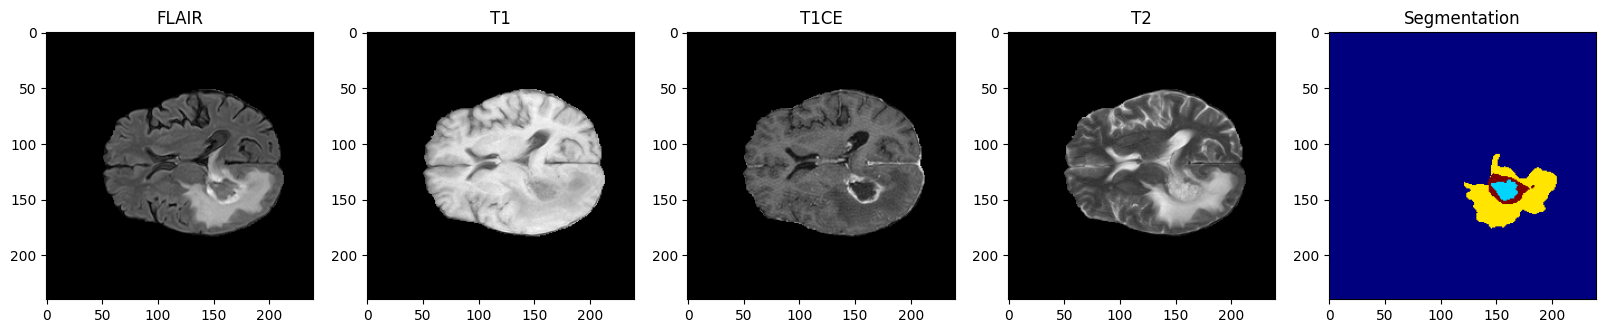

In [ ]:
#Display slices from all modalities for a given sample
def visualize_sample(flair_file, t1_file, t1ce_file, t2_file, seg_file, slice_idx=None):
    #Load volumes, files
    flair = nib.load(flair_file).get_fdata()
    t1 = nib.load(t1_file).get_fdata()
    t1ce = nib.load(t1ce_file).get_fdata()
    t2 = nib.load(t2_file).get_fdata()
    seg = nib.load(seg_file).get_fdata()

    #Use the middle slice if no slice index is provided
    slice_idx = slice_idx or flair.shape[2] // 2

    #Plot all modalities and segmentation mask
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    axes[0].imshow(flair[:, :, slice_idx], cmap='gray')
    axes[0].set_title("FLAIR")
    axes[1].imshow(t1[:, :, slice_idx], cmap='gray')
    axes[1].set_title("T1")
    axes[2].imshow(t1ce[:, :, slice_idx], cmap='gray')
    axes[2].set_title("T1CE")
    axes[3].imshow(t2[:, :, slice_idx], cmap='gray')
    axes[3].set_title("T2")
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet')
    axes[4].set_title("Segmentation")
    plt.show()

#Visualize first sample
visualize_sample(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])

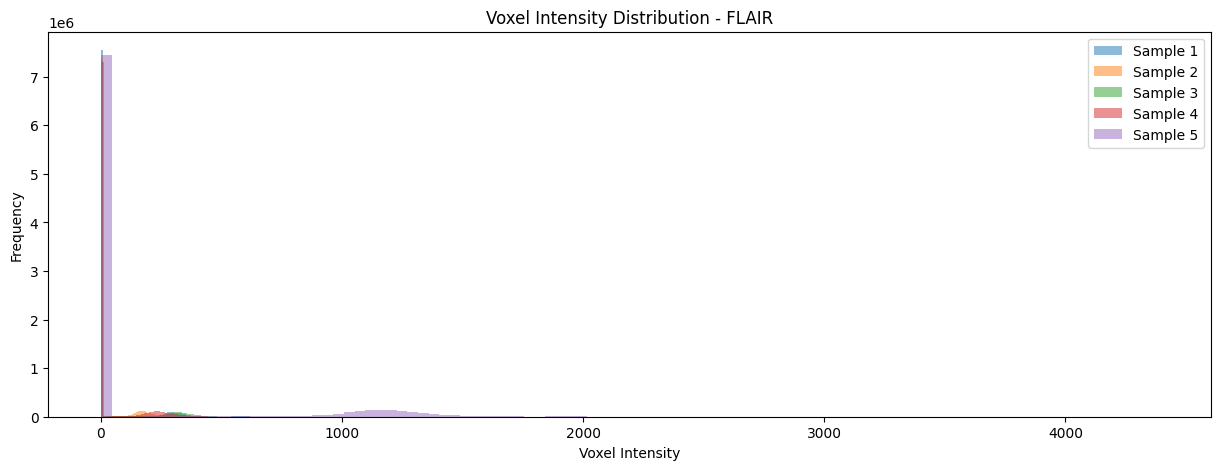

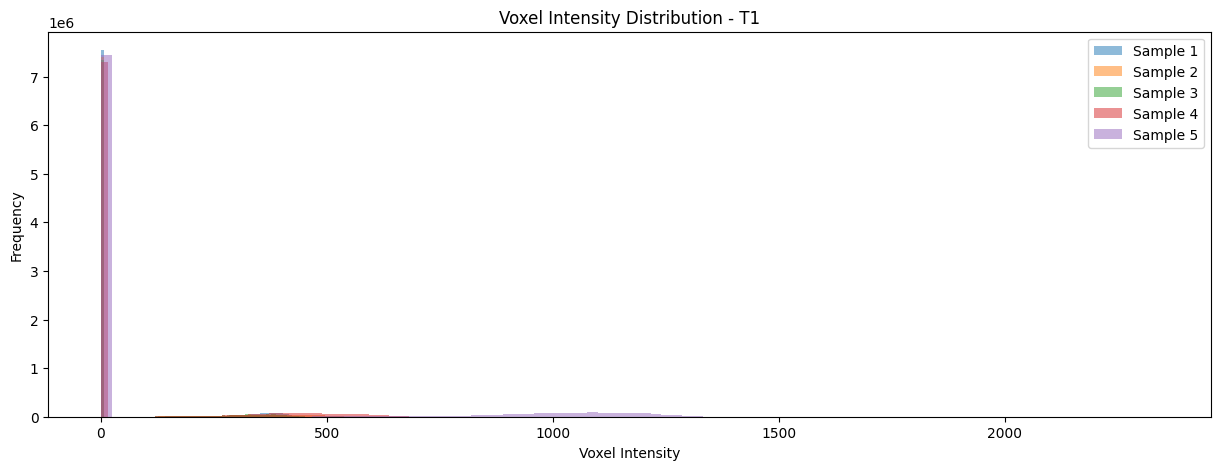

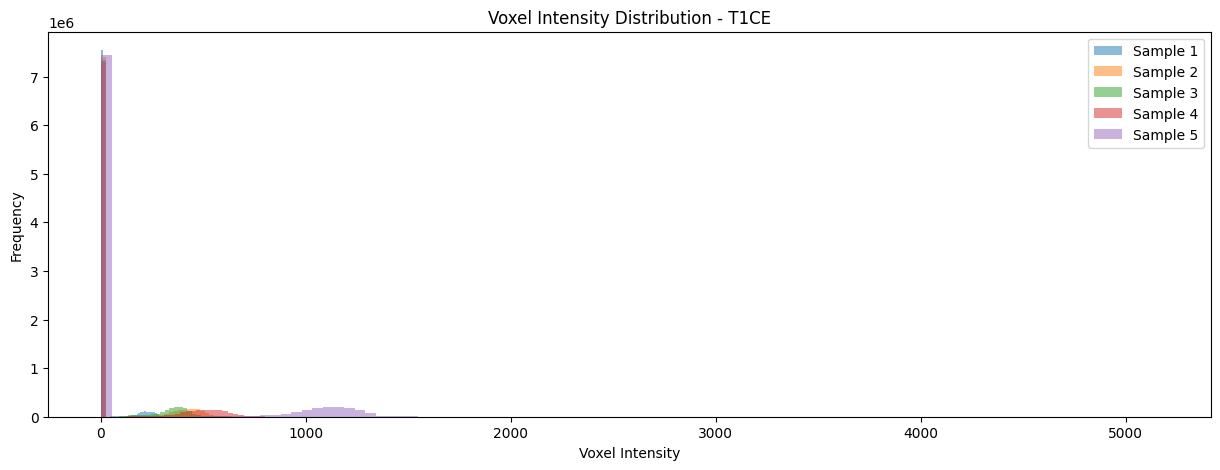

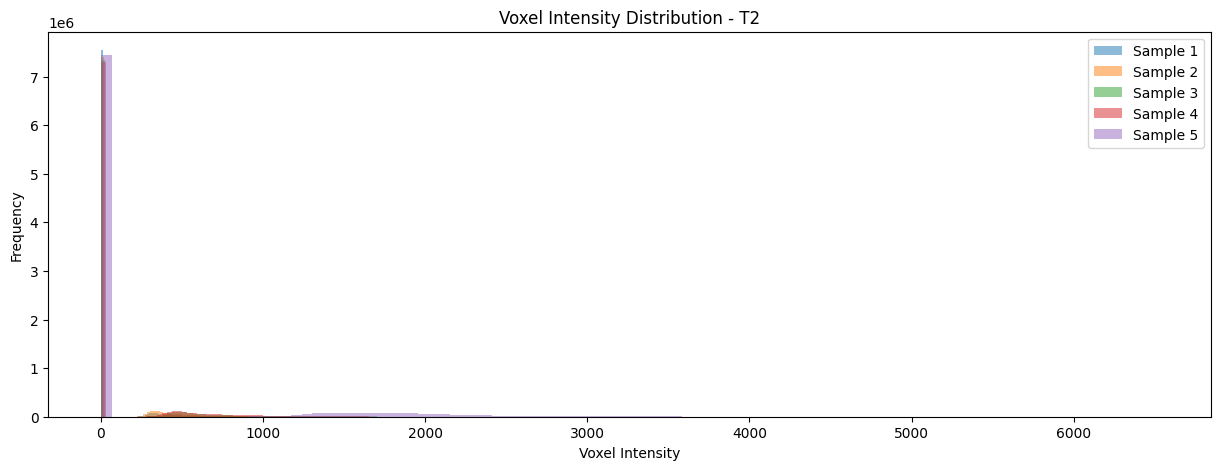

In [ ]:
#Histograms for voxel intensities
def voxel_distributions(file_paths, modality_name, num_samples=5):
    plt.figure(figsize=(15, 5))
    #Check first few samples
    for i, file_path in enumerate(file_paths[:num_samples]):
        #Load volume data from file
        volume = nib.load(file_path).get_fdata()
        #Plot intensity
        plt.hist(volume.flatten(), bins=100, alpha=0.5, label=f"Sample {i+1}")
    plt.title(f"Voxel Intensity Distribution - {modality_name}")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot distributions for each modality
voxel_distributions(flair_files, "FLAIR")
voxel_distributions(t1_files, "T1")
voxel_distributions(t1ce_files, "T1CE")
voxel_distributions(t2_files, "T2")

In [ ]:
#Data splitting for training and validating. Will approach with standard 80/20 split
indices = list(range(len(flair_files)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=37)
#Print amount of instances in each to verify proper split
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")

Number of training samples: 791
Number of validation samples: 198


In [ ]:
#Data Generator for data loading and preprocessing across full dataset
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, indices, batch_size=2, augment=False, useful_threshold=0.03):
        #Indices of dataset
        self.indices = indices
        #Samples per batch
        self.batch_size = batch_size
        #Applying data augmentation
        self.augment = augment
        #Threshold for uesful data based on non-zero voxel proportion
        self.useful_threshold = useful_threshold

    def __len__(self):
        #Calculate number of batches per epoch to understand resource allocation
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        #Fetch one batch of data based on index with batch specific indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        #Initialized lists for input data and lables (X and y respectively)
        X, y = [], []
        for i in batch_indices:
            #Load all modalities for given index (up to 1253)
            flair = nib.load(flair_files[i]).get_fdata()
            t1 = nib.load(t1_files[i]).get_fdata()
            t1ce = nib.load(t1ce_files[i]).get_fdata()
            t2 = nib.load(t2_files[i]).get_fdata()
            seg = nib.load(seg_files[i]).get_fdata()

            #Check if the data volume contains enough "useful" non-zero voxels
            if (
                self._useful_volume(flair) < self.useful_threshold or
                self._useful_volume(t1) < self.useful_threshold or
                self._useful_volume(t1ce) < self.useful_threshold or
                self._useful_volume(t2) < self.useful_threshold
            ):
                print(f"[INFO] Skipping patient {i} due to insufficient useful volume.")
                continue

            #Stack modalities as channels along last axis
            input_image = np.stack([flair, t1, t1ce, t2], axis=-1)

            #Pad the depth dimension from 155 to 160 so we can feed it through the model w/o error
            pad_diff = 160 - input_image.shape[2]
            #If depth is less than 160, pad with 0
            if pad_diff > 0:
                input_image = np.pad(input_image, ((0, 0), (0, 0), (0, pad_diff), (0, 0)), mode='constant')
                seg = np.pad(seg, ((0, 0), (0, 0), (0, pad_diff)), mode='constant')

            #Normalize each modality independently to [0,1]
            input_image[..., 0] = self._normalize(input_image[..., 0])
            input_image[..., 1] = self._normalize(input_image[..., 1])
            input_image[..., 2] = self._normalize(input_image[..., 2])
            input_image[..., 3] = self._normalize(input_image[..., 3])

            #Convert segmentation mask to categorical format for multi-class segmentation
            seg = to_categorical(seg, num_classes=5)

            #Data augmentation
            if self.augment:
                #Randomly decide to augment
                if random.random() > 0.5:
                    #Generate random rotation angle
                    angle = random.uniform(-10, 10)
                    #Rotate image
                    input_image = rotate(input_image, angle, axes=(0, 1), reshape=False, mode='nearest')
                    #Rotate segmentation mask
                    seg = rotate(seg, angle, axes=(0, 1), reshape=False, mode='nearest')
            #Append preprocessed input to batch
            X.append(input_image)
            #Append preprocessed segmentation to batch too
            y.append(seg)
        #Return as Numpy array
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def _normalize(self, volume):
        """Normalize a 3D volume to the range [0, 1]."""
        return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    def _useful_volume(self, volume):
        """Calculate the proportion of useful volume (non-zero voxels)."""
        return 1 - (np.sum(volume == 0) / volume.size)

In [ ]:
#Instantiate training and validation generators
train_generator = DataGenerator(indices=train_indices, batch_size=4, augment=True, useful_threshold=0.03)
val_generator = DataGenerator(indices=val_indices, batch_size=4, augment=False, useful_threshold=0.03)

In [ ]:
#Training instances applied
train_total_instances = len(train_generator.indices)
print(f"Total number of training instances: {train_total_instances}")

#Validation instances applied
val_total_instances = len(val_generator.indices)
print(f"Total number of validation instances: {val_total_instances}")

Total number of training instances: 791
Total number of validation instances: 198


In [ ]:
def unet_model(input_shape):
    #Input layer accepting 3D image with 4 channels (1 per modality)
    inputs = Input(input_shape)

    #Contracting Path (Encoder)
    #First block is to extrat features and reduce spatial dimesnions
    #Begin with 32 filter convolutional layer
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    #Normalize activations (improves convergence)
    conv1 = BatchNormalization()(conv1)
    #Additional convolution
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    #Downsample volume by factor of 2
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    #Second block with deeper feature extraction
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    #Third block (feature extraction continued)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    #Bottleneck. Captures high level features with reduced spatial resolution
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    #First Expansive Path (Decoder)
    #First block: Upsample and concatenate features from the contracting path
    up5 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    #Skip connection with corresponding encoder layer
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    #Second block with continued upsampling and concatenating
    up6 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    #Third block with upsampling
    up7 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    #Output layer with prediction of segmentation map with 5 classes (softmax generates probabilities to determine)
    outputs = Conv3D(5, (1, 1, 1), activation='softmax')(conv7)

    #Model variable with input/output layers
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


#Input shape with even depth to prevent mismatches
#Depth is even number (power of 2) with 4 channels
input_shape = (240, 240, 160, 4)
#instantiate model
model = unet_model(input_shape)
#Summarize model architecture for parameter check
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 160, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 240, 240,  │      3,488 │ input_layer[0][0] │
│                     │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 240, 240,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 240, 240,  │     27,680 │ batch_normalizat… │
│                     │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 240, 240,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 120, 120,  │     55,360 │ max_pooling3d[0]… │
│                     │ 80, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 80, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 120, 120,  │    110,656 │ batch_normalizat… │
│                     │ 80, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 80, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 60, 60,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 60, 60,    │    221,312 │ max_pooling3d_1[… │
│                     │ 40, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        512 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 40, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 60, 60,    │    442,496 │ batch_normalizat… │
│                     │ 40, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        512 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 40, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 30, 30,    │    884,992 │ max_pooling3d_2[

 Total params: 5,608,069 (21.39 MB)

 Trainable params: 5,605,253 (21.38 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
#Dice loss to measure overlap between predicted mask and ground truth
dice_loss = DiceLoss()
#Penalize pixel-wize misclassifications
crossentropy_loss = CategoricalCrossentropy()

In [ ]:
#Combined losses to balance region-level and pizel-level accuracy
@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + crossentropy_loss(y_true, y_pred)

In [ ]:
#Metrics for segmentation performace
#Intersection-Over-Union for overlap eval
#F1 Score for region precision/recall
#Pizel-wise accuracy
metrics = [IOUScore(threshold=0.5), FScore(threshold=0.5), 'accuracy']

In [ ]:
#Reduced learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    #Validation loss
    monitor='val_loss',
    #One-third the learning rate
    factor=0.3,
    #Wait 2 epochs without improvement
    patience=2,
    #Minimum LR
    min_lr=1e-4,
    #Print updates
    verbose=1
)


In [ ]:
#Checkpoint callback
checkpoint = ModelCheckpoint(
    #Model name w/ epoch
    filepath='model_checkpoint_epoch_{epoch:02d}.keras',
    #Validation loss
    monitor='val_loss',
    #only best model is saved
    save_best_only=True,
    #When val loss is minimized
    mode='min',
    #print out information on model
    verbose=1
)

In [ ]:
#Hopefully prevents overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    #Stop when val loss doesnt improve
    monitor='val_loss',
    #Wait 3 epochs before stopping
    patience=3,
    #Revert to best weights
    restore_best_weights=True
    )

In [ ]:
#Custom wrappers to ensure proper deserialization
@register_keras_serializable(package="Custom", name="IOUScore")
def custom_iou_score(**kwargs):
    return IOUScore(**kwargs)

@register_keras_serializable(package="Custom", name="FScore")
def custom_fscore(**kwargs):
    return FScore(**kwargs)

In [ ]:
#Compile the model with loss, optimizer, metrics
model.compile(optimizer='adam', loss=combined_loss, metrics=metrics)

In [ ]:
#Train model with generators, callbacks
history = model.fit(
    #Data Generator
    train_generator,
    #Validation generator
    validation_data=val_generator,
    #Iterations, try few others next
    epochs=4,
    #Display progress during training
    verbose=1,
    #Learning rate reduction, early stopping
    callbacks=[reduce_lr, early_stopping, checkpoint]
    )

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 72s/step - accuracy: 0.8437 - f1-score: 0.1965 - iou_score: 0.1528 - loss: 2.0148  
Epoch 1: val_loss improved from inf to 16.51822, saving model to model_checkpoint_epoch_01.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 17603s 84s/step - accuracy: 0.8442 - f1-score: 0.1973 - iou_score: 0.1536 - loss: 2.0124 - val_accuracy: 0.0157 - val_f1-score: 0.0059 - val_iou_score: 0.0030 - val_loss: 16.5182 - learning_rate: 0.0010
Epoch 2/4
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 72s/step - accuracy: 0.9924 - f1-score: 0.6423 - iou_score: 0.5629 - loss: 0.8046  
Epoch 2: val_loss improved from 16.51822 to 0.88958, saving model to model_checkpoint_epoch_02.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 17015s 84s/step - accuracy: 0.9924 - f1-score: 0.6424 - iou_score: 0.5629 - loss: 0.8043 - val_accuracy: 0.9799 - val_f1-score: 0.3436 - val_iou_score: 0.2904 - val_loss: 0.8896 - learning_rate: 0.0010
Epoch 3/4
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 69s/step - accuracy: 0.9929 - f1-score: 0.6817 - iou_sc

In [68]:
model.save('Modified_Model_10_epochs.keras')

In [ ]:
def metrics_plot(history):
    #Extract metrics from history
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]
    for metric in metrics:
        plt.figure(figsize=(10, 8))
        plt.plot(history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
def print_metrics(history):
    #Extract metrics from history
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]

    for metric in metrics:
        #Print all values
        print(f"\n{metric.capitalize()} Values Over Epochs:")
        print(f"Training {metric}: {history.history[metric]}")
        if f"val_{metric}" in history.history:
            print(f"Validation {metric}: {history.history[f'val_{metric}']}")

In [ ]:
#Call function to see results
print_metrics(history)

NameError: name 'history' is not defined

In [69]:
model.save('/content/Modified_Model_10_epochs.keras')

In [ ]:
def model_checkpoints(folder_path="./"):
    #Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    #Collect all .keras files in the folder
    keras_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]
    if not keras_files:
        print("No .keras files found in the specified folder.")
        return

    #Zip file name
    zip_file_name = "Model_10_epochs.keras.zip"

    #Zip only .keras files
    with zipfile.ZipFile(zip_file_name, 'w') as zipf:
        for file in keras_files:
            zipf.write(os.path.join(folder_path, file), arcname=file)

    print(f"Zipped .keras files from '{folder_path}' into '{zip_file_name}'")

    #Download
    try:
        files.download(zip_file_name)
        print("Download started...")
    except Exception as e:
        print(f"Error during download: {e}")


In [ ]:
#Save everything
model_checkpoints()

Zipped .keras files from './' into 'Model_10_epochs.keras.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...


In [75]:
model = load_model('/content/model_checkpoint_epoch_02.keras', compile=False)

In [ ]:
#Refine the predicted segmentation masks
def post_process_prediction(prediction):
    #Convert predictions to class labels
    prediction = prediction.argmax(axis=-1)
    #Apply morphological closing to fill gaps and remove noise
    #Loop through each slice in depth
    for i in range(prediction.shape[2]):
        #Convert to 8-bit for morphological operations, use 5x5 kernel
        prediction[:, :, i] = cv2.morphologyEx(prediction[:, :, i].astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    return prediction

In [ ]:
def add_outline(image, mask, outline_color=(255, 0, 0)):
    #Normalize the input image to range [0, 255] if necessary
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    #Detect edges using Canny edge detection
    edges = cv2.Canny(mask.astype(np.uint8) * 255, threshold1=50, threshold2=150)

    #Convert grayscale to RGB
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    #Add the outline to the RGB image
    overlay[edges > 0] = outline_color

    return overlay

In [ ]:
def class_color(mask):
    unique_labels = np.unique(mask)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))[:, :3] * 255

    print("Class-Color Mapping:")
    for label, color in zip(unique_labels, colors):
        print(f"Class {int(label)}: RGB {tuple(color.astype(int))}")

In [76]:
import scipy.ndimage as ndi

# Clean noise in predicted mask
def clean_prediction(mask, min_size=100):
    cleaned = np.zeros_like(mask)
    for class_id in np.unique(mask):
        if class_id == 0:
            continue
        class_mask = (mask == class_id)
        labeled, num_features = ndi.label(class_mask)
        for i in range(1, num_features + 1):
            if np.sum(labeled == i) > min_size:
                cleaned[labeled == i] = class_id
    return cleaned

# Visualize predictions with colored segmentation and outline
def predictions_colored_segmentation(model, index):
    # Grab input and ground truth for the batch
    X, y_true = train_generator[index]

    # Normalize if needed
    if X.max() > 1.0:
        X = X / X.max()

    # Predict segmentation
    y_pred = model.predict(X)[0]  # shape: (H, W, D, C)

    # Post-processing (custom function assumed)
    y_pred_post_processed = post_process_prediction(y_pred)  # shape: (H, W, D)

    # Extract a single slice for visualization
    slice_index = X[0].shape[2] // 2
    input_slice = X[0][:, :, slice_index, 0]
    ground_truth_slice = y_true[0][:, :, slice_index].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, slice_index]

    # Clean up predicted mask
    predicted_slice = clean_prediction(predicted_slice)

    # Print class-color mapping
    print("Predicted Segmentation Class-Color Mapping:")
    class_color(predicted_slice)

    # Add colored segmentation and outline
    predicted_with_colors_and_outline = colored_segmentation_outline(input_slice, predicted_slice)

    # Plot everything
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_colors_and_outline)
    axes[3].set_title('Predicted Segmentation with Colors and Outline')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step
Predicted Segmentation Class-Color Mapping:
Class-Color Mapping:
Class 0: RGB (np.int64(0), np.int64(0), np.int64(127))
Class 2: RGB (np.int64(124), np.int64(255), np.int64(121))
Class 3: RGB (np.int64(127), np.int64(0), np.int64(0))


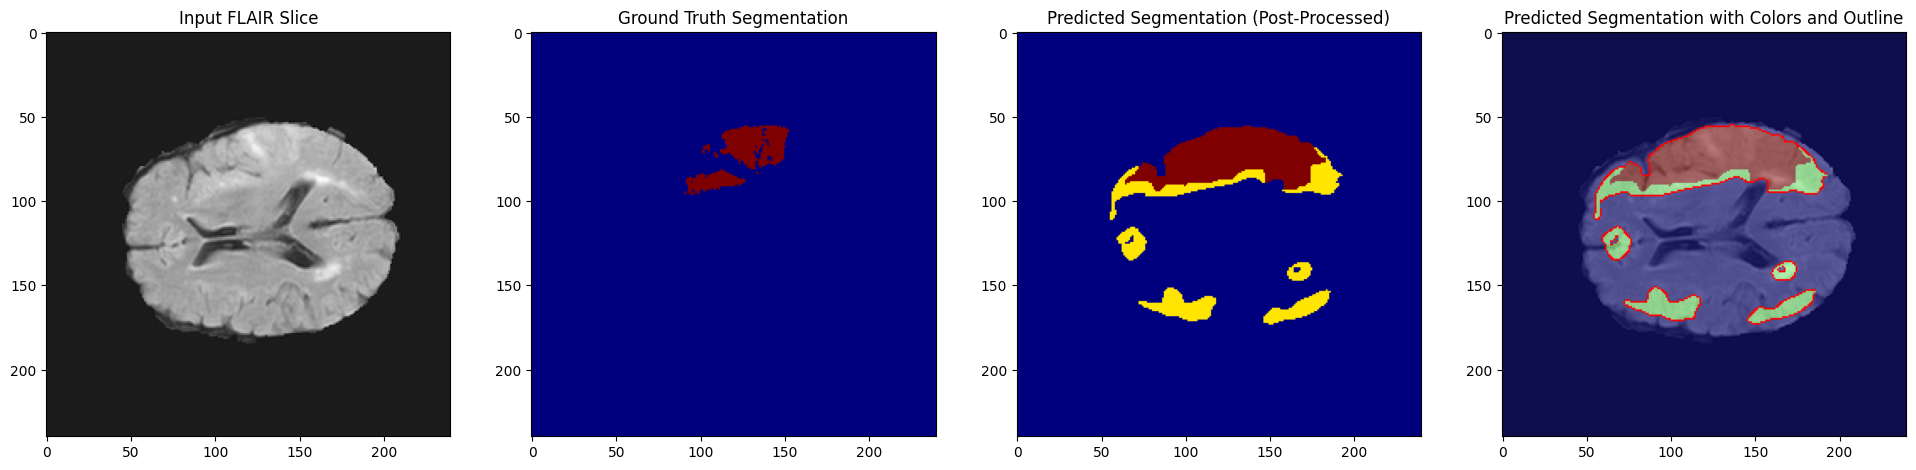

In [77]:
predictions_colored_segmentation(model, index=10)

In [ ]:
def colored_segmentation_outline(image, mask, outline_color=(255, 0, 0)):
    #Normalize the input image to range [0, 255]
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    #Convert grayscale image to RGB
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    #Create a colored version of the mask
    colored_mask = np.zeros_like(overlay)
    unique_labels = np.unique(mask)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))[:, :3] * 255

    for label, color in zip(unique_labels, colors):
        colored_mask[mask == label] = color

    #Blend the colored mask with the image
    alpha = 0.5
    overlay = cv2.addWeighted(overlay, 1 - alpha, colored_mask, alpha, 0)

    #Detect edges
    edges = cv2.Canny(mask.astype(np.uint8) * 255, threshold1=50, threshold2=150)
    overlay[edges > 0] = outline_color

    return overlay

In [57]:
def gifs_3d(model, index, flair_output_path="flair_images.gif", segmentation_output_path="predicted_segmentation.gif"):
    #Grab input and ground truth for the batch
    X, _ = train_generator[index]
    # Predict segmentation
    y_pred = model.predict(X)[0]
    #Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)

    #Print class-color mapping for the first slice
    print("Class-Color Mapping for the First Predicted Slice:")
    class_color(y_pred_post_processed[:, :, 0])

    #Prepare directories for temporary frames
    temp_flair_dir = "temp_flair_frames"
    temp_seg_dir = "temp_seg_frames"
    os.makedirs(temp_flair_dir, exist_ok=True)
    os.makedirs(temp_seg_dir, exist_ok=True)

    #Create individual frames for each slice
    flair_frames = []
    seg_frames = []
    #Iterate through all slices in the depth dimension
    for i in range(X[0].shape[2]):
        #Extract the input FLAIR slice
        input_slice = X[0][:, :, i, 0]
        #Extract the predicted segmentation for the slice
        predicted_slice = y_pred_post_processed[:, :, i]

        #Save FLAIR slice as a frame
        flair_frame_path = os.path.join(temp_flair_dir, f"flair_frame_{i:03d}.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(input_slice, cmap="gray")
        plt.title(f"FLAIR Slice {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(flair_frame_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        flair_frames.append(flair_frame_path)

        #Add colored segmentation and outline
        overlay = colored_segmentation_outline(input_slice, predicted_slice)

        #Save segmentation slice as a frame
        seg_frame_path = os.path.join(temp_seg_dir, f"seg_frame_{i:03d}.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(overlay)
        plt.title(f"Predicted Segmentation Slice {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(seg_frame_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        seg_frames.append(seg_frame_path)

    #FLAIR GIF
    with imageio.get_writer(flair_output_path, mode="I", duration=0.1, loop=0) as writer:
        for frame in flair_frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    #Segmentation GIF
    with imageio.get_writer(segmentation_output_path, mode="I", duration=0.1, loop=0) as writer:
        for frame in seg_frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    #Clean up temporary frames
    for frame in flair_frames:
        os.remove(frame)
    os.rmdir(temp_flair_dir)

    for frame in seg_frames:
        os.remove(frame)
    os.rmdir(temp_seg_dir)

    print(f"FLAIR GIF saved as {flair_output_path}")
    print(f"Segmentation GIF saved as {segmentation_output_path}")

    #Display
    print("Displaying FLAIR GIF:")
    display(Image(flair_output_path))
    print("Displaying Segmentation GIF:")
    display(Image(segmentation_output_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Class-Color Mapping for the First Predicted Slice:
Class-Color Mapping:
Class 0: RGB (np.int64(0), np.int64(0), np.int64(127))


<ipython-input-47-c044f24c5a25>:3: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min()) * 255
<ipython-input-47-c044f24c5a25>:4: RuntimeWarning: invalid value encountered in cast
  image = image.astype(np.uint8)
<ipython-input-57-923b26ba1b1b>:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
<ipython-input-57-923b26ba1b1b>:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


FLAIR GIF saved as flair_images.gif
Segmentation GIF saved as predicted_segmentation.gif
Displaying FLAIR GIF:


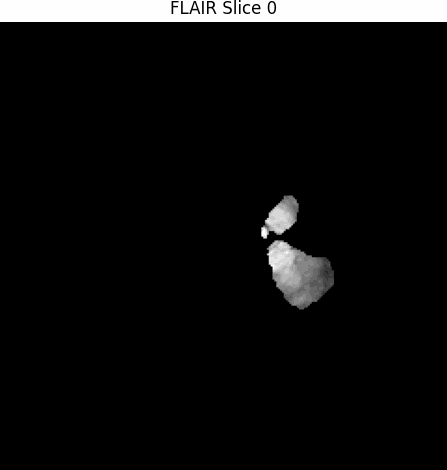

Displaying Segmentation GIF:


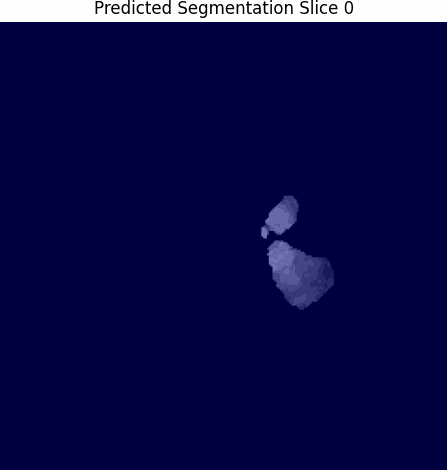

In [78]:
gifs_3d(
    model,
    index=0,
    flair_output_path="flair_images.gif",
    segmentation_output_path="predicted_segmentation.gif"
)

In [61]:
def outline_only_pred(model, index):
    #Grab input and ground truth for the batch
    X, y_true = train_generator[index]
    #Predict segmentation
    y_pred = model.predict(X)[0]
    #Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)
    #Extract a single slice for visualization
    input_slice = X[0][:, :, X[0].shape[2] // 2, 0]
    ground_truth_slice = y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, X[0].shape[2] // 2]

    #Add outline to the predicted segmentation
    predicted_with_outline = add_outline(input_slice, predicted_slice, outline_color=(255, 0, 0))

    #Plot truth, input, predictions, and overlayed outline
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_outline)
    axes[3].set_title('Predicted Segmentation with Brain Outline')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


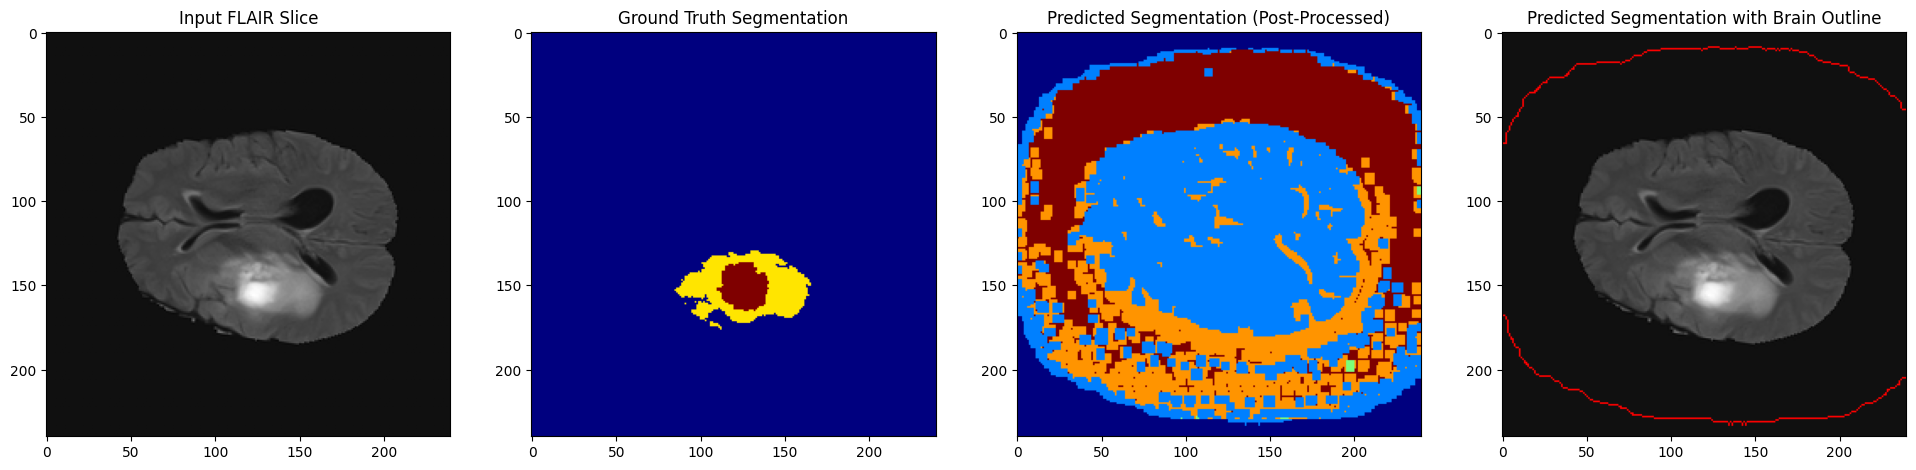

In [62]:
outline_only_pred(model, index=0)